In [23]:
import logging

import networkx as nx
import igraph as ig
import numpy as np

import pymetis
from sklearn import cluster

from evaluation import synthetic
from sharetrace import propagation
from synthetic import (
    DatasetFactory,
    ScoreFactory,
    UniformBernoulliValueFactory,
    Dataset, HistoryFactory, TimeFactory,
    LocationFactory,
    ContactFactory,
    ConnectedCavemanGraphFactory)

In [34]:
def adjlist(g: ig.Graph):
    return g.get_adjlist()


def adjmat(g: ig.Graph):
    return np.array(list(g.get_adjacency()))


def metis_partition(g: ig.Graph, parts: int):
    _, labels = pymetis.part_graph(parts, adjmat(g))
    return np.array(labels)


def spectral_partition(g: ig.Graph, parts: int):
    spectral = cluster.SpectralClustering(
        parts, affinity='precomputed', n_init=100, assign_labels='discretize')
    return spectral.fit_predict(adjmat(g))


def create_data(
        users: int = 10_000,
        days: int = 15,
        per_day: int = 16,
        low: float = -1,
        high: float = 1,
        step_low: float = -0.01,
        step_high: float = 0.01,
        p: float = 0.2,
        save: bool = False) -> Dataset:
    dataset_factory = DatasetFactory(
        score_factory=ScoreFactory(
            value_factory=UniformBernoulliValueFactory(per_user=days, p=p),
            time_factory=TimeFactory(days=days, per_day=1)),
        history_factory=HistoryFactory(
            loc_factory=LocationFactory(
                days=days,
                per_day=per_day,
                low=low,
                high=high,
                step_low=step_low,
                step_high=step_high),
            time_factory=TimeFactory(days=days, per_day=per_day)),
        contact_factory=ContactFactory(
            graph_factory=ConnectedCavemanGraphFactory(2),
            time_factory=TimeFactory(days=days, per_day=1, random_first=True)))
    dataset = dataset_factory(users)
    if save:
        dataset.save('.//data')
    return dataset


def cs_main():
    dataset = synthetic.create_data(5000, low=-2, high=2, save=False)
    cs = new_contact_search(logging.getLogger())
    contacts = cs.search(dataset.geohashes())


def rp_main():
    logger = logging.getLogger()
    dataset = synthetic.create_data(500, low=-5, high=5, save=False)
    # cs = new_contact_search(logger)
    # contacts = cs.search(dataset.geohashes())
    contacts = dataset.contacts
    for w in range(1, 5):
        rp = propagation.RiskPropagation(
            logger=logger, workers=w, timeout=3, tol=0.3)
        rp.run(dataset.scores, contacts)

In [3]:
colors = np.array(['blue', 'pink', 'green', 'brown'])

In [48]:
nxg = nx.generators.barbell_graph(10, 5)

In [ ]:
nxg = nx.generators.barbell_graph

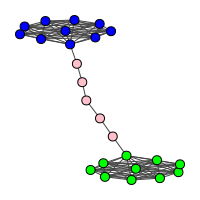

In [49]:
g = ig.Graph.from_networkx(nxg)
labels = spectral_partition(g, 3)
ig.plot(
    g,
    layout=g.layout_auto(),
    vertex_color=list(colors[labels]),
    vertex_size=9,
    bbox=(200, 200),
    margin=20)